# Survivor: Titanic
---
My attempt at the [Kaggle Titanic Competition](https://www.kaggle.com/c/titanic)

In [51]:
#imports

import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
import tensorflow as tf
import tensorflow.contrib.learn as skflow

In [6]:
# import data and take a looksee
df = pd.read_excel('_DATA/titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [11]:
# overall mean of survival
df_mean = df['survived'].mean()
print(df_mean)

0.381970970206


In [13]:
# mean by class
class_mean = df.groupby('pclass').mean()
print(class_mean)

        survived        age     sibsp     parch       fare        body
pclass                                                                
1       0.619195  39.159918  0.436533  0.365325  87.508992  162.828571
2       0.429603  29.506705  0.393502  0.368231  21.179196  167.387097
3       0.255289  24.816367  0.568406  0.400564  13.302889  155.818182


In [15]:
# group by class and sex
class_sex_grouping = df.groupby(['pclass', 'sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

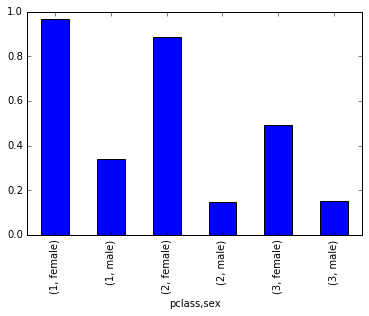

In [16]:
# plot class and sex results
class_sex_grouping['survived'].plot.bar()

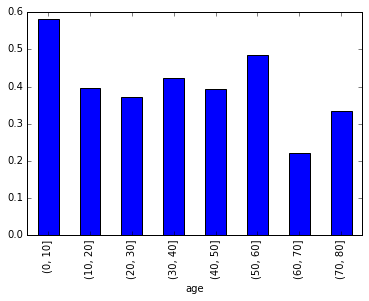

In [17]:
# plot by age
group_by_age = pd.cut(df['age'], np.arange(0, 90, 10))
age_grouping = df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

In [18]:
# count total values
df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [19]:
# replace empty data with nan and drop
df = df.drop(['body', 'cabin', 'boat'], axis=1)
df['home.dest'] = df['home.dest'].fillna('NA')
df = df.dropna()
df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [20]:
def preprocess_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    
    # drop non-categorical string values
    processed_df = processed_df.drop(['name', 
                                      'ticket', 
                                      'home.dest'
                                     ], axis=1)
    return processed_df

In [25]:
processed_df = preprocess_df(df)
print(processed_df.head(10))

   pclass  survived  sex      age  sibsp  parch      fare  embarked
0       1         1    0  29.0000      0      0  211.3375         2
1       1         1    1   0.9167      1      2  151.5500         2
2       1         0    0   2.0000      1      2  151.5500         2
3       1         0    1  30.0000      1      2  151.5500         2
4       1         0    0  25.0000      1      2  151.5500         2
5       1         1    1  48.0000      0      0   26.5500         2
6       1         1    0  63.0000      1      0   77.9583         2
7       1         0    1  39.0000      0      0    0.0000         2
8       1         1    0  53.0000      2      0   51.4792         2
9       1         0    1  71.0000      0      0   49.5042         0


In [31]:
# X contains all values except `survived`
X = processed_df.drop(['survived'], axis=1).values

# y only contains `survived` values
y = processed_df['survived'].values

In [33]:
# split both X and y into training and testing sets
X_train, X_test, y_train, y_test = (
    cross_validation.train_test_split(X,y,test_size=0.2)
)

In [38]:
# create a decision tree classifier w/ max depth of 10
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

# fit the classifier to our training set
clf_dt.fit(X_train, y_train)

# score our decision tree using our test data
clf_dt.score(X_test, y_test)

0.76555023923444976

In [41]:
# check with shuffle validator
shuffle_validator = cross_validation.ShuffleSplit(
    len(X), n_iter=20, test_size=0.2, random_state=0
)


# function that applies shuffle validator
def test_classifier(clf):
    scores = cross_validation.cross_val_score(
        clf, X, y, cv=shuffle_validator
    )
    print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))
    

In [42]:
test_classifier(clf_dt)

Accuracy: 0.7720 (+/- 0.02)


In [43]:
# Random Forest classifier
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7811 (+/- 0.03)


In [45]:
# Gradient Boosting classifier
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8201 (+/- 0.02)


In [46]:
# Voting classifier
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf),
                            ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.8010 (+/- 0.02)


## Deep Neural Networks
Here we will explore the dataset with TensorFlow to get a taste of deep neural network analysis. Yaay Backpropogation!

In [64]:
# Build a deep neural network classifier
tf_clf_dnn = skflow.TensorFlowDNNClassifier(
    hidden_units=[20, 40, 20], n_classes=2,
    batch_size=256, steps=1000, learning_rate=0.05
)

# Fit the DNN to our data
tf_clf_dnn.fit(X_train, y_train)

# Score the output
#tf_clf_dnn.score(X_test, y_test)

/Users/gary/.virtualenvs/py3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1197: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


TensorFlowDNNClassifier(learning_rate=0.05, batch_size=256, optimizer=Adagrad, steps=1000)

In [57]:
# create custom model
def custom_model(X, y):
    layers = skflow.ops.dnn(X, [20, 40, 20], tf.tanh)
    return skflow.models.logistic_regression(layers, y)

In [58]:
tf_clf_c = skflow.TensorFlowEstimator(model_fn=custom_model, n_classes=2, batch_size=256, steps=1000, learning_rate=0.05)
tf_clf_c.fit(X_train, y_train)
metrics.accuracy_score(y_test, tf_clf_c.predict(X_test))

0.76076555023923442

In [59]:
# lets look at individual passengers
passengers_set_1 = df[df.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = df[df.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = df[df.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1,passengers_set_2,passengers_set_3])
testing_set = preprocess_df(passenger_set)

In [60]:
training_set = pd.concat([df, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_df(training_set)

In [61]:
X_train = training_set.drop(['survived'], axis=1).values
y_train = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values

In [63]:
tf_clf_dnn.fit (X_train, y_train)
#tf_clf_dnn.score (X_test, y_test)

/Users/gary/.virtualenvs/py3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py:1197: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  result_shape.insert(dim, 1)


TensorFlowDNNClassifier(learning_rate=0.05, batch_size=256, optimizer=Adagrad, steps=1000)

In [65]:
prediction = tf_clf_dnn.predict(X_test)
passenger_set[passenger_set.survived != prediction]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,S,"New York, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,C,"Montevideo, Uruguay"
14,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S,"Hessle, Yorks"
16,1,0,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,C,"Montreal, PQ"
19,1,0,"Beattie, Mr. Thomson",male,36.0,0,0,13050,75.2417,C,"Winnipeg, MN"
336,2,1,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,S,"Norwich / New York, NY"
341,2,1,"Becker, Miss. Ruth Elizabeth",female,12.0,2,1,230136,39.0000,S,"Guntur, India / Benton Harbour, MI"
342,2,1,"Becker, Mrs. Allen Oliver (Nellie E Baumgardner)",female,36.0,0,3,230136,39.0000,S,"Guntur, India / Benton Harbour, MI"
